In [2]:
from __future__ import division

#import random_idx
#import utils
import pickle
import time
import scipy
import scipy.special
import string
from pylab import *
%matplotlib inline

plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Computer Modern']})

In [3]:
#h = np.load('data/decay_info-lN=4-lD=10-ll=75-n161011.npz')
h = np.load('data/decay_info-lN=4-lD=10-ll=75-n161105.npz')

test_ll = h['test_ll']
test_N = h['test_N']
t = h['t']
test_D = h['test_D']
info_max = h['info_max']


figures/decay_max_info-N=4000-lD=10-n170914


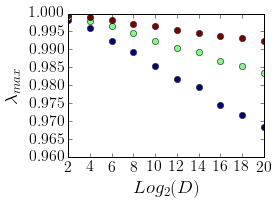

In [4]:
figure(figsize=(4,3))

cols = get_cmap('jet', len(test_N)-1)
for iN, N in enumerate(test_N[:3]):
    if True: #iN == 0 or iN == (len(test_N)-1):
        plot(np.log2(test_D), test_ll[np.argmax(info_max[iN,:, :], axis=1)], 
             'o', lw=2, color=cols(iN), label='$N = %i$' % N)
    else:
        plot(np.log2(test_D), test_ll[np.argmax(info_max[iN,:, :], axis=1)], 
             'o', lw=2, color=cols(iN))

xlabel('$Log_2 (D)$')
ylabel('$\lambda_{max}$')
#legend(loc='lower left', numpoints=1)
ylim([0.96, 1.0])

plt.tight_layout()

fname = 'figures/decay_max_info-N=' + str(int(N)) + '-lD=' +str(len(test_D)) + '-n' + time.strftime('%y%m%d')
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

figures/decay_timeconstant_info-tau-N=4000-lD=10-n170914


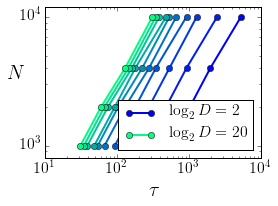

In [5]:
figure(figsize=(4,3))

cols = get_cmap('winter', len(test_D))
for iD, D in enumerate(test_D):
    
    if iD == 0 or iD == len(test_D)-1:
        plot(-1/np.log(test_ll[np.argmax(info_max[:,iD,:], axis=1)]), test_N, '-o',
             lw=2, c=cols(iD), label=r"$\log_2 D=%i$" % np.log2(D))
    else:
        plot(-1/np.log(test_ll[np.argmax(info_max[:,iD,:], axis=1)]), test_N, '-o',
             lw=2, c=cols(iD))


xlabel(r"$\tau$", fontsize=20)
ylabel('$N$', rotation='horizontal', fontsize=20)
#ylabel('$\lambda_{max}$')
#legend(loc='lower left', numpoints=1)
#ylim([0, 10500])
legend(loc='lower right')

xscale('log')
yscale('log')
ylim([8e2,12e3])
plt.tight_layout()

fname = 'figures/decay_timeconstant_info-tau-N=' + str(int(N)) + '-lD=' +str(len(test_D)) + '-n' + time.strftime('%y%m%d')
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

## White 2004 and Ganguli 2008

There are several disconnects to this work, but a lot of things can be pieced back together. 

Ganguli08:

"Transient Amplification and Extensive Memory
Comparing Eqs. 5 and 9 motivates defining networks with extensive memory as networks in which Jtot is proportional to N for large N. With this definition, normal networks do not have extensive memory."

In this work, the network is affected by noise, and this noise accumulates with time. Eventually, the noise accumulation will build up and drown out any of the signal. However, this does not mean that the networks cannot achieve extensive memory. A network which can reset (and clear out the noise) can have extensive memory for finite time, or M. Further, networks that have decay or non-linearity can indeed achieve extensive memory in the presence of noise without reset throug the recency effect. 

In [6]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_noise(M, N=10000, D=27, noise_std=0.1, ares=2000):
    
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N + noise_std**2 * N * Mval)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N + noise_std**2 * N * Mval)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N + noise_std**2 * N * Mval)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [7]:
def p_correct_decay(M,ll=1, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
    
    dM = (1 / (1 - ll**2))
    
    for iM,Mval in enumerate(M):
        avals = np.linspace(N * ll ** Mval - 8 * (N*dM)**0.5, N * ll ** Mval + 8 * (N*dM)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N * ll ** Mval) / ((dM)*N)**0.5) - ncdf((avals[:-1]-N * ll ** Mval) / ((dM)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(dM*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [8]:

def p_correct_snr(s, D=27, ares=2000):
    p = np.zeros((ares-1, len(s)))

    for isnr, snr in enumerate(s):
        # span the Hit distribution up to 8 standard deviations @todo: make parameter
        avals = np.linspace(snr - 8, snr + 8, ares)
        
        # the discretized gaussian of the hit
        p[:, isnr] = ncdf((avals[1:]-snr)) - ncdf((avals[:-1]-snr))
        # times the discretized cumulative gaussian of the reject
        p[:, isnr] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0))) ** (D-1)
        
    return np.sum(p, axis=0) # integrate over the avals



/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in power


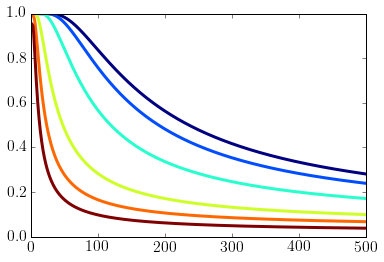

In [9]:

test_noise = [0.1, 0.5, 1, 2, 3, 4]
cols = get_cmap('jet', len(test_noise))


N=1000
D=32
M = np.arange(500)

for idx_noise,noise_std in enumerate(test_noise):
    p_correct = p_correct_noise(M, N=N, D=32, noise_std=noise_std)
    plot(M, p_correct, color=cols(idx_noise),lw=3, label="noise: %1.1f" % noise_std)



In [25]:
def test_capacity_decay_lookback_noise(N, D, decay=1, noise_std=0.1, trials=25e3):
    -

In [36]:
test_N = [1000]
test_D = [32]

test_ll = [0.99 ]
test_std = [0.2, 0.5, 1.0, 2.0]

#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
run_D = []
run_ll = []
run_std = []

lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []


for r in range(runs):
    print r
    for N in test_N:
        for ll in test_ll:
            for D in test_D:
                for nstd in test_std:
                    lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_decay_lookback_noise(N, D, decay=ll, noise_std=nstd)

                    run_id.append(r)
                    run_N.append(N)
                    run_D.append(D)
                    run_ll.append(ll)
                    run_std.append(nstd)
                    lidx_all.append(lidx)
                    lidx_li_all.append(lidx_li)
                    lidx_iK_all.append(lidx_iK)
                    lidx_fi_all.append(lidx_fi)

                
filename = ("data/hypervector_capacity_decay_noise-N=" + str(test_N) + '-D=' + str(len(test_D)) +'-ll' + str(len(test_ll)) 
            + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'  )
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, run_D=run_D, run_ll=run_ll, runs=runs, test_N=test_N, test_D=test_D, decay=decay)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packa

Duration:  7.78756690025
Duration:  7.78012180328
Duration:  7.78382396698
Duration:  7.69617795944
1
Duration:  7.5721590519
Duration:  7.62919592857
Duration:  7.67101693153
Duration:  7.58470606804
2
Duration:  7.69733500481
Duration:  7.66830420494
Duration:  7.61556005478
Duration:  7.65311479568
3
Duration:  7.56851887703
Duration:  7.76334691048
Duration:  7.49305891991
Duration:  7.69057393074
4
Duration:  7.54142904282
Duration:  7.59115505219
Duration:  7.59612202644
Duration:  7.6387629509
data/hypervector_capacity_decay_noise-N=[1000]-D=1-ll1-r=5-n170815.npz


In [77]:
test_N = [1000]
test_D = [32]

test_ll = [0.99 ]
test_std = [0.2, 0.5, 1.0, 2.0]


In [78]:
run_id = np.array(run_id)
run_std = np.array(run_std)
run_ll = np.array(run_ll)

ustd = unique(run_std)
ull = unique(run_ll)
test_ll = ull

li_mean = np.zeros((lidx_li_all[0].shape[0], len(ustd), len(ull)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(ustd), len(ull)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(ustd), len(ull)))

for ill, ll in enumerate(ull):
    for inoise, nstd in enumerate(ustd):
        idxs = find(np.logical_and(run_std==nstd, run_ll==ll))
        for i in idxs:
            li_mean[:,inoise, ill] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
            #iK_mean[:,iD] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
            iK_mean[:,inoise, ill] += np.array(lidx_all[i] == lidx_iK_all[i], 'int32')                             
            fi_mean[:,inoise, ill] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')

li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


figures/decay_net_lookback_theory_noise-N=1000-ll=1-n170815


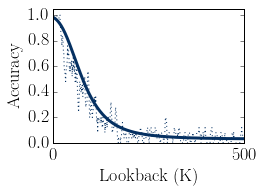

In [38]:
figure(figsize=(4,3))

cm=get_cmap('RdBu', iK_mean.shape[2])
smoothN=5
pcd=[]
for i in range(iK_mean.shape[2]):
    #plot(li_mean[:,i], color=cm(i))
    plot(arange(iK_mean.shape[0], 0, -1)[:-5],
         np.convolve(iK_mean[:,1,i], np.ones(smoothN)/smoothN, mode='same')[:-5], ':', 
         color=cm(i), lw=1)
    
    pcd.append(p_correct_decay(arange(iK_mean.shape[0])+1, ll=test_ll[i], N=N, D=test_D[0]))
    plot(arange(iK_mean.shape[0]), pcd[i], lw=3, color=cm(i),
                        # label="ll: 1-1e%i" % np.log10(1 - test_ll[i]).round())
                        label="$\lambda = %.04f$" % test_ll[i])
    
#legend(loc='upper right');
xlabel('Lookback (K)');
ylabel('Accuracy')
ylim([0, 1.05])
ax = gca()
ax.set_xticks(arange(0, 2002, 500))
xlim([0, 500])

plt.tight_layout()

fname = ('figures/decay_net_lookback_theory_noise-N='+str(int(N)) 
         + '-ll=' + str(len(test_ll)) + '-n' + time.strftime('%y%m%d'))
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

figures/decay_net_lookback_theory_noise-N=1000-ll=1-n170816


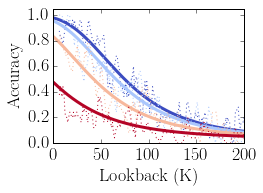

In [79]:
figure(figsize=(4,3))

N = test_N[0]
cm=get_cmap('coolwarm', iK_mean.shape[1])
smoothN=5
pcd=[]

M = arange(iK_mean.shape[0])+1

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    
    plot(arange(iK_mean.shape[0], 0, -1)[:-5],
         np.convolve(iK_mean[:,i,0], np.ones(smoothN)/smoothN, mode='same')[:-5], ':', 
         color=cm(i), lw=1)
    
    ss = test_ll[0]**M * (N*(1-test_ll[0]**2) / (1+test_std[i]**2))**0.5 
    
    pcd.append(p_correct_snr(ss, D=test_D[0]))
    plot(arange(iK_mean.shape[0]), pcd[i], lw=3, color=cm(i),
                        # label="ll: 1-1e%i" % np.log10(1 - test_ll[i]).round())
                        label="$\sigma_\eta = %.04f$" % test_std[i])
    
legend(loc='upper right');
xlabel('Lookback (K)');
ylabel('Accuracy')
ylim([0, 1.05])
ax = gca()
ax.set_xticks(arange(0, 202, 50))
xlim([0, 200])

plt.tight_layout()

fname = ('figures/decay_net_lookback_theory_noise-N='+str(int(N)) 
         + '-ll=' + str(len(test_ll)) + '-n' + time.strftime('%y%m%d'))
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

In [393]:
from scipy.optimize import minimize

def white_q_opt(q, N=1000, alpha=0.99, noise_eps=1e-4):
    kk = np.arange(N*2)
    
    return (0.72 - 1/N * np.sum(alpha**kk * q/(1+alpha**kk * q)) - (noise_eps)* q/(1-alpha))**2


In [210]:
N =  400
alpha = 0.999

q_res = minimize(white_q_opt, N*(1-alpha), (N, alpha))
qq = N*(1-alpha)

print q_res.x, qq, white_q_opt(q_res.x, N, alpha), white_q_opt(qq, N, alpha)

[ 0.70980551] 0.4 [  1.44844162e-16] 0.063469555021


[ 1992.24485393] 119.9880012
[ 226.82619512] 19.9980002
[ 10.72854039] 3.99960004
[ 0.70980551] 0.399960004
figures/decay_net_lookback_theory_noise-N=400-ll=4-n170914


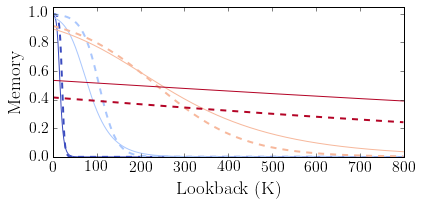

In [211]:
figure(figsize=(6,3))

test_ll = [0.7, 0.95, 0.99, 0.999]
noise_eps = 1e-4
N=400
q=N
cm=get_cmap('coolwarm', len(test_ll))
smoothN=5
pcd=[]
n_inputs = 800
K = arange(n_inputs) #arange(iK_mean.shape[0])+1

for i in range(len(test_ll)):
    #plot(li_mean[:,i], color=cm(i))
    
    ll = test_ll[i]
    ll2 = ll**0.5
    
    ss = ll2**K * (N*(1-ll2**2) / (1+(noise_eps)))**0.5 
    #ss = ll2**K * (N*(1-ll2**2) / ((1+(noise_eps)**2) *(1-ll**n_inputs)))**0.5 
    
    pcd.append(p_correct_snr(ss, D=2))
    #plot(M, 2*pcd[i]-1, lw=3, color=cm(i),
                        # label="ll: 1-1e%i" % np.log10(1 - test_ll[i]).round())
    #                    label="$ll = %.04f$" % test_ll[i])
    
    rho = ss/(ss**2+1)**0.5
    plot(M, rho, color=cm(i))
    
    nstd = noise_eps #test_std[i]/N**0.5
    #gang_m = ll ** M / (ll ** M + nstd/(1-ll) * (1 - ll **(M+1)))
    #gang_m = ll ** M / (ll ** M + nstd/(1-ll) )
    #gang_m = ll ** M * q / (q * ll ** M + (1+noise_eps)/(1-ll) )
    
    q = N * (1-ll)/(1+noise_eps)
    #gang_m = ll ** M * q / (q * ll ** M + 1)
    
    q_res = minimize(white_q_opt, q, (N, ll, noise_eps))
    qq = q_res.x
    print qq, q
    gang_m = ll ** K * qq / ( qq * ll ** K + 1)
    
    #gang_m = ll ** M / (ll ** M + noise_eps/(1-ll) * (1 - ll **(M+1)))

    plot(M, gang_m, "--", color=cm(i), lw=2)
    
#legend(loc='upper right');
xlabel('Lookback (K)');
ylabel('Memory')
ylim([0, 1.05])
ax = gca()
#ax.set_xticks(np.rounlinspace(0, 802, 50))
xlim([0, 800])

plt.tight_layout()

fname = ('figures/decay_net_lookback_theory_noise-N='+str(int(N)) 
         + '-ll=' + str(len(test_ll)) + '-n' + time.strftime('%y%m%d'))
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

In [619]:

test_ll = [0.7, 0.95, 0.99, 0.999]
n_runs = 20

noise_eps = 1e-4
N=400
D=27
M = int(5*N)
Kmax = 2*N#800
recon_sequence = np.zeros((n_runs, len(test_ll), Kmax, D))
regress_sequence = np.zeros((n_runs, len(test_ll), Kmax, D, M))
tst  =time.time()


encode_vec = np.random.randn(N, D)
input_sequence = np.random.randn(n_runs, M, D)

for ill, alpha in enumerate(test_ll):

    memory_vec = np.zeros(N)

    memory_hist_matrix = np.zeros((M, N))
    memory_regress_train = np.zeros((M, M, D))

    train_sequence = np.random.randn(M, D)

    for iM in range(M):
        memory_vec = alpha**0.5 * np.roll(memory_vec, 1) + np.dot(train_sequence[iM, :], encode_vec.T) + noise_eps**0.5 * np.random.randn(N)
        memory_hist_matrix[iM, :] = memory_vec
        memory_regress_train[iM, :(iM+1), :] = train_sequence[iM::-1, :]

    
    readout_matrix = np.zeros((N, D))
    for iD in range(D):
        regress_readout = np.linalg.lstsq(memory_hist_matrix[Kmax:, :], memory_regress_train[Kmax:, :Kmax, iD])
        readout_matrix[:, iD] = regress_readout[0].mean(axis=1)
    
    for irun in range(n_runs):
        memory_vec = np.zeros(N)

        for iM in range(M):
            memory_vec = alpha**0.5 * np.roll(memory_vec, 1) + np.dot(input_sequence[irun, iM, :], encode_vec.T) + noise_eps**0.5 * np.random.randn(N)

            regress_sequence[irun, ill, :, :, iM] = np.dot(memory_vec, readout_matrix)

        for iK in range(Kmax):
            recon_sequence[irun, ill, iK, :] = alpha**(-0.5*iK) * np.dot(encode_vec.T, np.roll(memory_vec, -iK)) / N


    print "%0.2f" % (time.time()-tst),

24.314 49.087 74.557 104.272


In [630]:

input_lookback = np.zeros((n_runs, len(test_ll), Kmax, D, M-Kmax))
readout_lookback = np.zeros((n_runs, len(test_ll), Kmax, D, M-Kmax))

for ill, alpha in enumerate(test_ll):
    for iM in range(Kmax, M):
        input_lookback[:, ill, :, :, iM-Kmax] = input_sequence[:, iM:(iM-Kmax):-1, :] - np.mean(input_sequence[:, iM:(iM-Kmax):-1, :], axis=1)[:, np.newaxis, :]
        readout_lookback[:, ill, :, :, iM-Kmax] = regress_sequence[:, ill, :, :, iM] - np.mean(regress_sequence[:, ill, :, :, iM], axis=1)[:, np.newaxis, :]
    

KeyboardInterrupt: 

(0, 1.1)

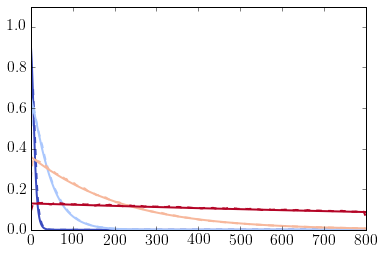

In [620]:
ill = 0
cols = get_cmap('coolwarm', len(test_ll))

for ill, alpha in enumerate(test_ll):
    #error = ((input_sequence[:, :-Kmax-1:-1] - recon_sequence[:, ill, :])**2)**0.5
    error = np.mean((input_sequence[:, :-Kmax-1:-1, :] - recon_sequence[:, ill, :, :])**2, axis=2)**0.5
    ss = 1/error
    mm = ss**2/(ss**2+1)
    
    #mm = input_sequence[:, :-Kmax-1:-1] * recon_sequence[:, ill, :]  / std(recon_sequence[:, ill, :], axis=0) / std(input_sequence[:, :-Kmax-1:-1], axis=0)

    smoothN = 10
    mm_smooth = np.convolve( mm.mean(axis=0) , np.ones(smoothN)/smoothN, mode='same')
    plot(mm_smooth**0.5, '--', lw=2, c=cols(ill))
    
    K = arange(len(mm_smooth))
    s = alpha ** (0.5*K) * (N*(1-alpha)/(1-alpha**M)/(1+noise_eps)/D)**0.5
    ms = s**2/(s**2+1)
    
    plot(ms**0.5, lw=2, c=cols(ill))

ylim([0, 1.1])

In [628]:
ill = 0
cols = get_cmap('coolwarm', len(test_ll))

for ill, alpha in enumerate(test_ll):
    #error = ((input_sequence[:, :-Kmax-1:-1] - recon_sequence[:, ill, :])**2)**0.5
    #error = np.mean((input_sequence[:, :-Kmax-1:-1, :] - regress_sequence[:, ill, :, :, -1])**2, axis=2)**0.5
    #ss = 1/error
    #mm = ss**2/(ss**2+1)
    
    mm = (np.mean(input_sequence[:, :-Kmax-1:-1, :] * regress_sequence[:, ill, :, :, -1], axis=2)  
                 / std(regress_sequence[:, ill, :, :, -1], axis=0) 
                 / std(input_sequence[:, :-Kmax-1:-1, :], axis=0))

    smoothN = 10
    mm_smooth = np.convolve( mm.mean(axis=0) , np.ones(smoothN)/smoothN, mode='same')
    plot(mm_smooth**0.5, '--', lw=2, c=cols(ill))
    
    K = arange(len(mm_smooth))
    s = alpha ** (0.5*K) * (N*(1-alpha)/(1-alpha**M)/(1+noise_eps)/D)**0.5
    ms = s**2/(s**2+1)
    
    plot(ms**0.5, lw=2, c=cols(ill))

ylim([0, 1.1])

ValueError: operands could not be broadcast together with shapes (20,800) (800,27) 

In [627]:
mm.shape



(20, 27)

5.246 10.998 16.405 22.424


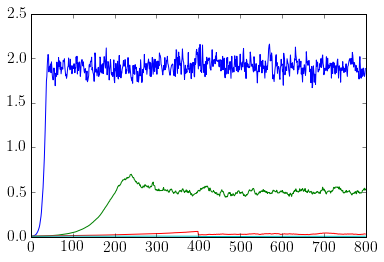

In [599]:

test_ll = [0.7, 0.95, 0.99, 0.999]
n_runs = 20

noise_eps = 1e-4
N=400
M = int(5*N)
Kmax = 2*N#800
recon_sequence = np.zeros((n_runs, len(test_ll), Kmax))
regress_sequence = np.zeros((n_runs, len(test_ll), Kmax, M))
tst  =time.time()


encode_vec = np.random.randn(N)
input_sequence = np.random.randn(n_runs, M)

for ill, alpha in enumerate(test_ll):

    memory_vec = np.zeros(N)

    memory_hist_matrix = np.zeros((M, N))
    memory_regress_train = np.zeros((M, M))

    train_sequence = np.random.randn(M)

    for iM in range(M):
        memory_vec = alpha**0.5 * np.roll(memory_vec, 1) + train_sequence[iM] * encode_vec + noise_eps**0.5 * np.random.randn(N)
        memory_hist_matrix[iM, :] = memory_vec
        memory_regress_train[iM, :(iM+1)] = train_sequence[iM::-1]

    regress_readout = np.linalg.lstsq(memory_hist_matrix[Kmax:, :], memory_regress_train[Kmax:, :Kmax])

    plot(std(regress_readout[0], axis=0))
    
    for irun in range(n_runs):
        memory_vec = np.zeros(N)

        for iM in range(M):
            memory_vec = alpha**0.5 * np.roll(memory_vec, 1) + input_sequence[irun, iM] * encode_vec + noise_eps**0.5 * np.random.randn(N)

            regress_sequence[irun, ill, :, iM] = np.dot(memory_vec, regress_readout[0])

        for iK in range(Kmax):
            recon_sequence[irun, ill, iK] = alpha**(-0.5*iK) * np.dot(encode_vec, np.roll(memory_vec, -iK)) / N


    print "%0.3f" % (time.time()-tst),

(0, 1.1)

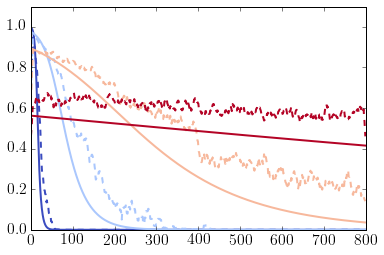

In [600]:
ill = 0
cols = get_cmap('coolwarm', len(test_ll))

for ill, alpha in enumerate(test_ll):
    #error = ((input_sequence[:, :-Kmax-1:-1] - recon_sequence[:, ill, :])**2)**0.5
    error = ((input_sequence[:, :-Kmax-1:-1] - recon_sequence[:, ill, :])**2)**0.5
    ss = 1/error
    mm = ss**2/(ss**2+1)
    
    #mm = input_sequence[:, :-Kmax-1:-1] * recon_sequence[:, ill, :]  / std(recon_sequence[:, ill, :], axis=0) / std(input_sequence[:, :-Kmax-1:-1], axis=0)

    smoothN = 10
    mm_smooth = np.convolve( mm.mean(axis=0) , np.ones(smoothN)/smoothN, mode='same')
    plot(mm_smooth**0.5, '--', lw=2, c=cols(ill))
    
    K = arange(len(mm_smooth))
    s = alpha ** (0.5*K) * (N*(1-alpha)/(1-alpha**M)/(1+noise_eps))**0.5
    ms = s**2/(s**2+1)
    
    plot(ms**0.5, lw=2, c=cols(ill))

ylim([0, 1.1])

In [601]:
input_sequence.shape

(20, 2000)

In [602]:

input_lookback = np.zeros((n_runs, len(test_ll), Kmax, M-Kmax))
readout_lookback = np.zeros((n_runs, len(test_ll), Kmax, M-Kmax))

for ill, alpha in enumerate(test_ll):
    for iM in range(Kmax, M):
        input_lookback[:, ill, :, iM-Kmax] = input_sequence[:, iM:(iM-Kmax):-1] - np.mean(input_sequence[:, iM:(iM-Kmax):-1], axis=1)[:, np.newaxis]
        readout_lookback[:, ill, :, iM-Kmax] = regress_sequence[:, ill, :, iM] - np.mean(regress_sequence[:, ill, :, iM], axis=1)[:, np.newaxis]
    

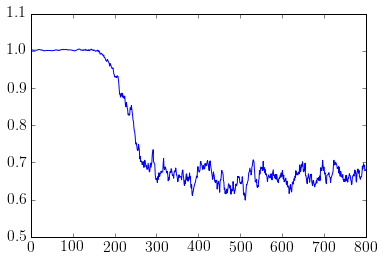

In [603]:
ill=1
plot(mean(std(readout_lookback[:, ill, :, :], axis=2), axis=0))

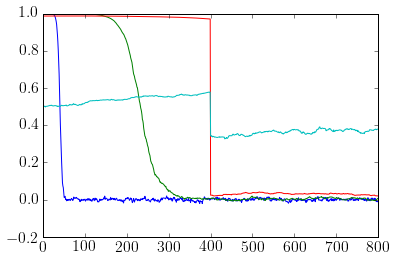

In [604]:
correlations = np.mean(np.mean(input_lookback * readout_lookback, axis=3)/np.std(input_lookback, axis=3)/np.std(readout_lookback, axis=3), axis=0)

plot(correlations.T)

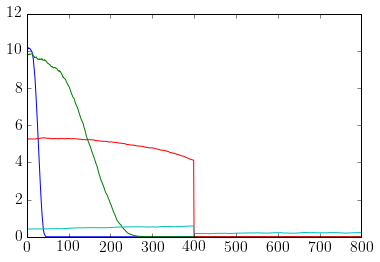

In [605]:
plot(-np.log2(1 - correlations.T ** 2))

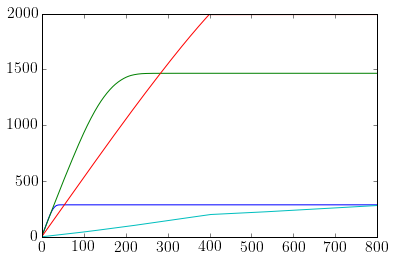

In [606]:
plot(np.cumsum(-np.log2(1 - correlations.T ** 2), axis=0))

[ 1969.86640569] 0.399960004
[ 226.73132129] 0.399960004
[ 10.7243996] 0.399960004
[ 0.70980551] 0.399960004


(0, 2.5)

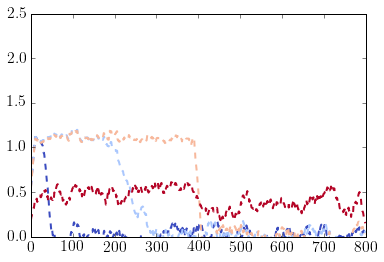

In [525]:
ill = 0
cols = get_cmap('coolwarm', len(test_ll))

for ill, alpha in enumerate(test_ll):
    #error = ((input_sequence[:, :-Kmax-1:-1] - regress_sequence[:, ill, :])**2)**0.5
    #ss = 1/error
    #mm = ss**2/(ss**2+1)
    
    mm = input_sequence[:, :-Kmax-1:-1] * regress_sequence[:, ill, :, -1] / std(regress_sequence[:, ill, :, -1], axis=0) / std(input_sequence[:, :-Kmax-1:-1], axis=0)
    smoothN = 20
    mm_smooth = np.convolve(mm.mean(axis=0), np.ones(smoothN)/smoothN, mode='same')
    plot(mm_smooth, '--', lw=2, c=cols(ill))
    
    K = arange(len(mm_smooth))
    s = alpha ** (0.5*K) * (N*(1-alpha)/(1-alpha**M))**0.5
    ms = s**2/(s**2+1)
    #plot(ms, ':',lw=2, c=cols(ill))

    
    q_res = minimize(white_q_opt, q, (N, alpha, noise_eps))
    qq = q_res.x
    print qq, q
    gang_m = alpha ** K * qq / ( qq * alpha ** K + 1)
    #plot(gang_m, lw=2, c=cols(ill))
    
ylim([0, 2.5])

[ 2034.52780942] 0.399960004
[ 290.21906073] 0.399960004
[ 29.45029407] 0.399960004
[ 0.96801515] 0.399960004


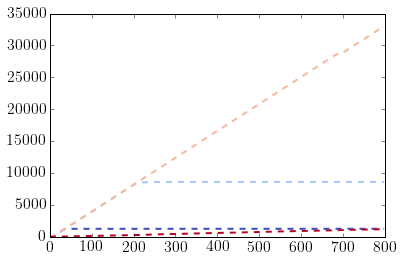

In [498]:
ill = 0
cols = get_cmap('coolwarm', len(test_ll))

for ill, alpha in enumerate(test_ll):
    #error = ((input_sequence[:, :-Kmax-1:-1] - regress_sequence[:, ill, :])**2)**0.5
    #ss = 1/error
    #mm = ss**2/(ss**2+1)
    
    mm = input_sequence[:, :-Kmax-1:-1] * regress_sequence[:, ill, :] / std(regress_sequence[:, ill, :], axis=0) / std(input_sequence[:, :-Kmax-1:-1], axis=0)
    smoothN = 20
    mm_smooth = np.convolve(mm.mean(axis=0), np.ones(smoothN)/smoothN, mode='same')
    
    mm_smooth[mm_smooth>1] = 0.9999999999999
    info= -np.log2(1-mm_smooth**2)
    plot(np.cumsum(info), '--', lw=2, c=cols(ill))
    
    K = arange(len(mm_smooth))
    s = alpha ** (0.5*K) * (N*(1-alpha)/(1-alpha**M))**0.5
    ms = s**2/(s**2+1)
    #plot(ms, ':',lw=2, c=cols(ill))

    
    q_res = minimize(white_q_opt, q, (N, alpha, noise_eps))
    qq = q_res.x
    print qq, q
    gang_m = alpha ** K * qq / ( qq * alpha ** K + 1)
    #plot(gang_m, lw=2, c=cols(ill))
    
#ylim([0, 1.1])

(0, 800)

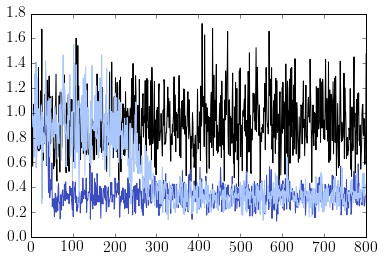

In [490]:
plot(std(input_sequence[:, :], axis=0), 'k')

for ill, alpha in enumerate([0,1]):
    plot(std(regress_sequence[:, ill, :], axis=0), c=cols(ill))
    
xlim([0, N])

(0, 10)

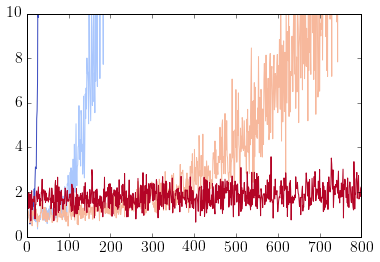

In [486]:
for ill, alpha in enumerate(test_ll):
    plot(std(recon_sequence[:, ill, :], axis=0), c=cols(ill))
    
ylim([0, 10])

[ 1969.86640569] 0.399960004
[ 226.73132129] 0.399960004
[ 10.7243996] 0.399960004
[ 0.70980551] 0.399960004


(0, 1.1)

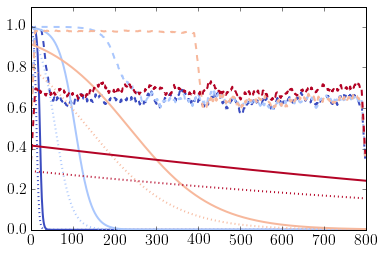

In [452]:
ill = 0
cols = get_cmap('coolwarm', len(test_ll))

for ill, alpha in enumerate(test_ll):
    error = ((input_sequence[:, :-Kmax-1:-1] - regress_sequence[:, ill, :])**2)**0.5
    ss = 1/error
    mm = ss**2/(ss**2+1)
    
    #mm = input_sequence[:, :-Kmax-1:-1] * regress_sequence[:, ill, :]
    smoothN = 20
    mm_smooth = np.convolve(mm.mean(axis=0), np.ones(smoothN)/smoothN, mode='same')
    plot(mm_smooth, '--', lw=2, c=cols(ill))
    
    K = arange(len(mm_smooth))
    s = alpha ** (0.5*K) * (N*(1-alpha)/(1-alpha**M))**0.5
    ms = s**2/(s**2+1)
    plot(ms, ':',lw=2, c=cols(ill))

    
    q_res = minimize(white_q_opt, q, (N, alpha, noise_eps))
    qq = q_res.x
    print qq, q
    gang_m = alpha ** K * qq / ( qq * alpha ** K + 1)
    plot(gang_m, lw=2, c=cols(ill))
    
ylim([0, 1.1])

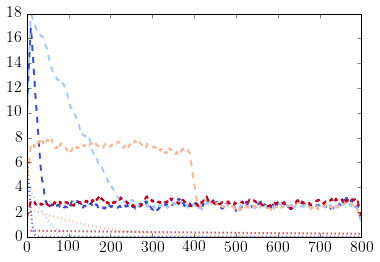

In [450]:
ill = 0
cols = get_cmap('coolwarm', len(test_ll))

for ill, alpha in enumerate(test_ll):
    error = ((input_sequence[:, :-Kmax-1:-1] - regress_sequence[:, ill, :])**2)**0.5
    ss = 1/error
    mm = np.log2(ss**2+1)# ss**2/(ss**2+1)
    
    #mm = input_sequence[:, :-Kmax-1:-1] * regress_sequence[:, ill, :]
    smoothN = 20
    mm_smooth = np.convolve(mm.mean(axis=0), np.ones(smoothN)/smoothN, mode='same')
    plot(mm_smooth, '--', lw=2, c=cols(ill))
    
    K = arange(len(mm_smooth))
    s = alpha ** (0.5*K) * (N*(1-alpha)/(1-alpha**M))**0.5
    ms = np.log2(s**2+1)# s**2/(s**2+1)
    plot(ms, ':',lw=2, c=cols(ill))

    
    #q_res = minimize(white_q_opt, q, (N, alpha, noise_eps))
    #qq = q_res.x
    #print qq, q
    #gang_m = alpha ** K * qq / ( qq * alpha ** K + 1)
    #plot(gang_m, lw=2, c=cols(ill))
    
#ylim([0, 1.1])

(0, 1)

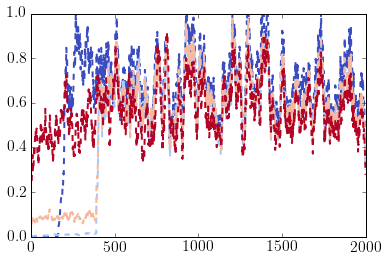

In [278]:
ill = 0
cols = get_cmap('coolwarm', len(test_ll))

for ill, alpha in enumerate(test_ll):
    error = ((input_sequence[::-1] - regress_sequence[ill, :])**2)**0.5
    ss = 1/error
    mm = ss**2/(ss**2+1)
    smoothN = 20
    mm_smooth = np.convolve(error, np.ones(smoothN)/smoothN, mode='same')
    plot(mm_smooth, '--', lw=2, c=cols(ill))
    
ylim([0, 1])

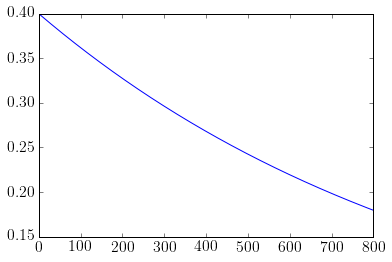

In [215]:
plot(ss**2)

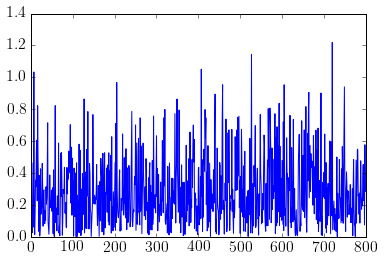

In [274]:
plot(error)

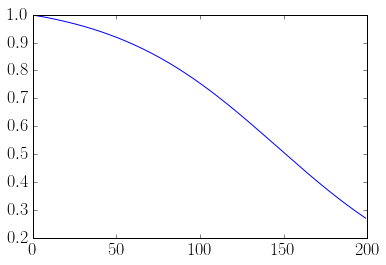

In [58]:
ll = test_ll[0]**2
nstd = test_std[2]**2/N
M = np.arange(200)
gang_m = ll ** M / (ll ** M + nstd/(1-ll) * (1 - ll **(M+1)))

plot(M, gang_m)

In [107]:
test_ll = 1 - np.logspace(-1.5, -5, 50)
#t = linspace(1, 100000, 100000)
#test_N = [int(1e3), int(1e4), int(1e5)]

test_N = [int(1e3), int(2e3), int(4e3), int(10e3)]
test_std = [0.5, 1.0, 1.5, 2.0]

cm = get_cmap('copper', len(test_ll))
#test_D = [8, 128, 4096]
D = 32
#test_D = [2.0**(k+1) for k in arange(1, 20, 2)]# np.logspace(0.3, 5, 10).round()

info_max = np.zeros((len(test_N), len(test_std), len(test_ll)))

for iN, N in enumerate(test_N):
    M= arange(N)+1
    print ""
    print N,
    tst = time.time()
    for istd, nstd in enumerate(test_std):  
        for il,ll in enumerate(test_ll):
            
            ss = ll**M * (N*(1-ll**2) / (1+nstd**2))**0.5 
    
            pcd = p_correct_snr(ss, D=D)
            info_decay = cumsum(pcd * log2(pcd*D) + (1-pcd) * log2(D/(D-1) * (1-pcd)))

            info_max[iN, istd, il] = info_decay.max()

         
        print int(time.time() - tst),
        
filename = 'data/decay_info-lN=' + str(len(test_N)) + '-lD=' + str(len(test_D)) + '-ll=' + str(len(test_ll)) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, test_ll=test_ll, test_N=test_N, t=t, test_D=test_D, info_max=info_max)




1000 24 48 73 97 
2000 46 92 143 192 
4000 94 184 275 366 
10000 222 445 668 892 data/decay_info-lN=4-lD=1-ll=50-n170816.npz


In [145]:
#h = np.load('data/decay_info-lN=4-lD=10-ll=75-n161011.npz')
h = np.load('data/decay_info-lN=4-lD=1-ll=50-n170816.npz')

test_ll = h['test_ll']
test_N = h['test_N']
t = h['t']
test_D = h['test_D']
info_max = h['info_max']
test_std = [0.5, 1.0, 1.5, 2.0]
D=32

figures/decay_max_info-noise-N=4000-lD=1-n170816


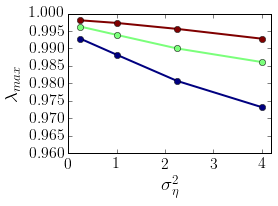

In [146]:
figure(figsize=(4,3))

cols = get_cmap('jet', len(test_N)-1)
for iN, N in enumerate(test_N[:3]):
    if True: #iN == 0 or iN == (len(test_N)-1):
        plot(np.array(test_std)**2, test_ll[np.argmax(info_max[iN,:, :], axis=1)], 
             '-o', lw=2, color=cols(iN), label='$N = %i$' % N)
    else:
        plot(np.array(test_std)**2, test_ll[np.argmax(info_max[iN,:, :], axis=1)], 
             '-o', lw=2, color=cols(iN))

xlabel('$\sigma^2_\eta$')
xlim([0, 4.2])
xticks(arange(5))
ylabel('$\lambda_{max}$')
#legend(loc='lower left', numpoints=1)
ylim([0.96, 1.0])

plt.tight_layout()

fname = 'figures/decay_max_info-noise-N=' + str(int(N)) + '-lD=' +str(len(test_D)) + '-n' + time.strftime('%y%m%d')
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

figures/decay_timeconstant_info-noise-tau-N=4000-lD=1-n170816


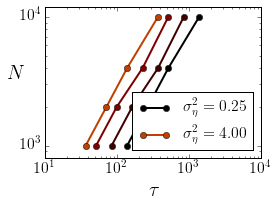

In [147]:
figure(figsize=(4,3))

cols = get_cmap('afmhot', len(test_std)+5)
for istd in range(0, len(test_std)):
    nstd = test_std[istd]
    if istd == 0 or istd == len(test_std)-1:
        plot(-1/np.log(test_ll[np.argmax(info_max[:,istd,:], axis=1)]), test_N, '-o',
             lw=2, c=cols(istd), label=r"$\sigma^2_\eta=%0.2f$" % nstd**2)
    else:
        plot(-1/np.log(test_ll[np.argmax(info_max[:,istd,:], axis=1)]), test_N, '-o',
             lw=2, c=cols(istd))


xlabel(r"$\tau$", fontsize=20)
ylabel('$N$', rotation='horizontal', fontsize=20)
#ylabel('$\lambda_{max}$')
#legend(loc='lower left', numpoints=1)
#ylim([0, 10500])
legend(loc='lower right')

xscale('log')
yscale('log')
ylim([8e2,12e3])
plt.tight_layout()

fname = 'figures/decay_timeconstant_info-noise-tau-N=' + str(int(N)) + '-lD=' +str(len(test_D)) + '-n' + time.strftime('%y%m%d')
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

figures/decay_noise_extensive_capcaity-noise-all-tau-N=10000-lD=1-n170816


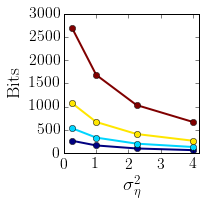

In [150]:
figure(figsize=(3,3))

cols = get_cmap('jet', len(test_N))
for iN, N in enumerate(test_N):
    
    plot(np.array(test_std)**2, info_max[iN,:,:].max(axis=1), '-o',
             lw=2, c=cols(iN), label=r"$\sigma_\eta=%0.1f$" % nstd)
    
#ylim([0, 0.3])
xlim([0, 4.2])
xticks(arange(5))
ylabel('Bits')
xlabel('$\sigma^2_\eta$')
plt.tight_layout()

fname = 'figures/decay_noise_extensive_capcaity-noise-all-tau-N=' + str(int(N)) + '-lD=' +str(len(test_D)) + '-n' + time.strftime('%y%m%d')
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

figures/decay_noise_extensive_capcaity-noise-tau-N=10000-lD=1-n170816


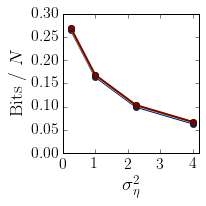

In [151]:
figure(figsize=(3,3))

cols = get_cmap('jet', len(test_N))
for iN, N in enumerate(test_N):
    
    plot(np.array(test_std)**2, info_max[iN,:,:].max(axis=1)/N, '-o',
             lw=2, c=cols(iN), label=r"$\sigma_\eta=%0.1f$" % nstd)
    
ylim([0, 0.3])
xlim([0, 4.2])
xticks(arange(5))
ylabel('Bits / $N$')
xlabel('$\sigma^2_\eta$')
plt.tight_layout()

fname = 'figures/decay_noise_extensive_capcaity-noise-tau-N=' + str(int(N)) + '-lD=' +str(len(test_D)) + '-n' + time.strftime('%y%m%d')
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

In [98]:
test_ll

array([ 0.96837722,  0.98221721,  0.99      ,  0.99437659,  0.99683772,
        0.99822172,  0.999     ,  0.99943766,  0.99968377,  0.99982217,
        0.9999    ,  0.99994377,  0.99996838,  0.99998222,  0.99999   ])

In [164]:
test_ll = [0.9] #1 - np.logspace(-1.5, -5, 50)
#t = linspace(1, 100000, 100000)
#test_N = [int(1e3), int(1e4), int(1e5)]

test_N = np.logspace(3, 5, 10) #[int(1e3), int(2e3), int(4e3), int(10e3)]
test_std = [0]

cm = get_cmap('copper', len(test_ll))
#test_D = [8, 128, 4096]
D = 32
#test_D = [2.0**(k+1) for k in arange(1, 20, 2)]# np.logspace(0.3, 5, 10).round()

info_max = np.zeros((len(test_N), len(test_std), len(test_ll)))

for iN, N in enumerate(test_N):
    M= arange(N/2)+1
    print ""
    print N,
    tst = time.time()
    for istd, nstd in enumerate(test_std):  
        for il,ll in enumerate(test_ll):
            
            ss = ll**M * (N*(1-ll**2) / (1+nstd**2))**0.5 
    
            pcd = p_correct_snr(ss, D=D)
            info_decay = cumsum(pcd * log2(pcd*D) + (1-pcd) * log2(D/(D-1) * (1-pcd)))

            info_max[iN, istd, il] = info_decay.max()

         
        print int(time.time() - tst),
        
filename = 'data/decay_info-lN=' + str(len(test_N)) + '-lD=' + str(len(test_D)) + '-ll=' + str(len(test_ll)) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, test_ll=test_ll, test_N=test_N, t=t, test_D=test_D, info_max=info_max)




1000.0 0 
1668.1005372 0 
2782.55940221 0 
4641.58883361 1 
7742.63682681 1 
12915.4966501 3 
21544.3469003 5 
35938.136638 8 
59948.4250319 14 
100000.0 24 data/decay_info-lN=10-lD=1-ll=1-n170817.npz


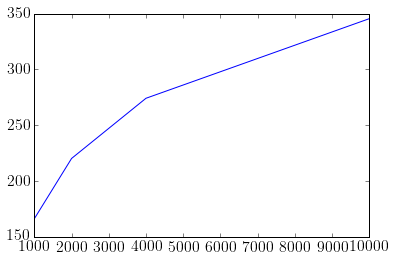

In [155]:
plot(test_N, info_max[:, 0, 0])

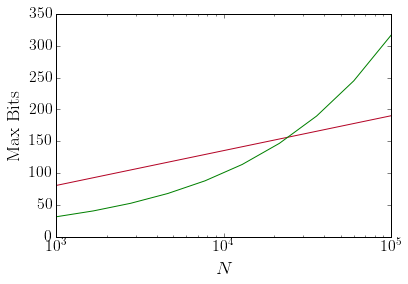

In [165]:
cols = get_cmap('coolwarm', len(test_ll))
for il, ll in enumerate(test_ll):
    plot(test_N, info_max[:, 0, il], c=cols(il))
    
plot(test_N, test_N**0.5)
xscale('log')
xlabel('$N$')
ylabel('Max Bits')

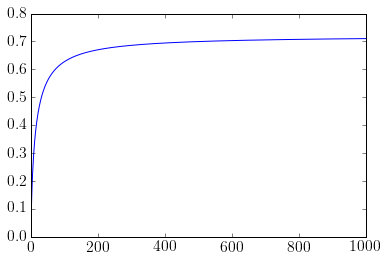

In [184]:
N=1000
M = arange(N)+1
D = 32

plot(M, M*D/2/N * np.log2((1+(M*D)/N)/((M*D)/N)))

In [39]:
s_eta

NameError: name 's_eta' is not defined

In [40]:
tN = np.logspace(3, 6, 10)
tD = tN/tN[0] #[1, 2, 4, 8, 16, 32, 64]

tinfo = [] #np.zeros((len(tN), len(tD)))
tst = time.time()
for iD,D in enumerate(tD):
    for iN, N in enumerate(tN):
        Mv = np.arange(5*N)+1
        s = (N/Mv/D) ** 0.5

        info = Mv*D/2 * np.log2(s**2+1)
        
        tinfo.append(info)

print 'elapsed:', time.time()-tst

elapsed: 4.27949595451


figures/coef_linear_maxinfo_N-lN=10-D=5-n170905


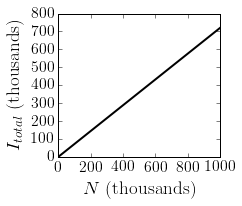

In [41]:
figure(figsize=(3.5,3))

c=0
iD_ex = 5

cols = get_cmap('jet', len(tN))
maxinfoN = np.zeros_like(tN)

for iD,D in enumerate(tD):
    for iN, N in enumerate(tN):
        if iD == iD_ex:
            maxinfoN[iN] = tinfo[c].max()
        c+=1
plot(tN/1000, maxinfoN/1000, 'k', lw=2)
#plot([0, Mv.max()], [1/2/np.log(2), 1/2/np.log(2)], '--k', lw=2)
        
xlabel('$N$ (thousands)')
ylabel('$I_{total}$ (thousands)')

plt.tight_layout()
fname = ('figures/coef_linear_maxinfo_N'
         + '-lN='+ str(len(tN))
         + '-D=' + str(iD_ex) + '-n' + time.strftime('%y%m%d'))
    
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)
#xscale('log')

figures/coef_extensive_linear-lN=10-D=5-n170905


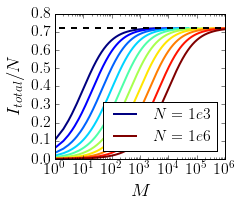

In [42]:
figure(figsize=(3.5,3))

c=0
iD_ex = 5

cols = get_cmap('jet', len(tN))

for iD,D in enumerate(tD):
    for iN, N in enumerate(tN):
        Mv = np.arange(len(tinfo[c]))+1
        
        if iD == iD_ex:
            if iN == 0 or iN == len(tN) -1:
                plot(Mv, tinfo[c]/N, c=cols(iN), lw=2, label="$N=1e%i$"%np.log10(N))
            else:
                plot(Mv, tinfo[c]/N, c=cols(iN), lw=2)
        c+=1

plot([0, Mv.max()], [1/2/np.log(2), 1/2/np.log(2)], '--k', lw=2)
        
xlim([1, 1e6])
xscale('log')
xlabel('$M$')
ylabel('$I_{total}/N$')

legend(loc='lower right')

plt.tight_layout()
fname = ('figures/coef_extensive_linear'
         + '-lN='+ str(len(tN))
         + '-D=' + str(iD_ex) + '-n' + time.strftime('%y%m%d'))
    
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)
#xscale('log')

figures/coef_extensive_linear-MtoN-lN=10-n170905


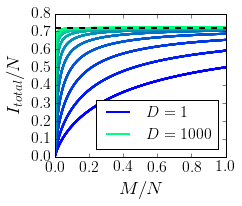

In [43]:
figure(figsize=(3.5,3))

c=0

cols = get_cmap('winter', len(tD))

for iD,D in enumerate(tD):
    for iN, N in enumerate(tN):
        Mv = np.arange(len(tinfo[c]))+1

        if iN == 0 and (iD == 0 or iD == len(tD)-1):
            plot(Mv/N, tinfo[c]/N, c=cols(iD), lw=2, label="$D=%i$"%D)
        else:
            plot(Mv/N, tinfo[c]/N, c=cols(iD), lw=2)
        c+=1

plot([0, 1], [1/2/np.log(2), 1/2/np.log(2)], '--k', lw=2)
        
xlim([1/tN.max(), 1])
legend(loc='lower right')
xlabel('$M/N$')
ylabel('$I_{total}/N$')
plt.tight_layout()
fname = ('figures/coef_extensive_linear-MtoN'
         + '-lN='+ str(len(tN))
         + '-n' + time.strftime('%y%m%d'))
    
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

#xscale('log')

In [44]:

from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

import matplotlib.pyplot as plt

pgf_with_latex = {
    "text.usetex": True,            # use LaTeX to write all text
    "pgf.rcfonts": False,           # Ignore Matplotlibrc
    "pgf.preamble": [
        r'\usepackage{color}'     # xcolor for colours
    ]
}
matplotlib.rcParams.update(pgf_with_latex)

pgf_with_latex = {
    "text.usetex": True,            # use LaTeX to write all text
    "pgf.rcfonts": False,           # Ignore Matplotlibrc
    "pgf.preamble": [
        r'\usepackage{color}'     # xcolor for colours
    ]
}
matplotlib.rcParams.update(pgf_with_latex)


figures/coef_extensive_linear-MDtoN-lN=10-n170907


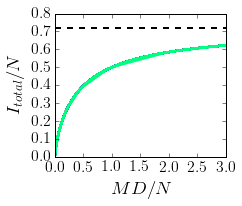

In [70]:
figure(figsize=(3.5,3))
ax1 = gca()
#ax2 = plt.twiny(ax1)
c=0
c_ex=arange(len(tinfo))

cols = get_cmap('winter', len(tD))

for iD,D in enumerate(tD):
    for iN, N in enumerate(tN):
        if c in c_ex:
            Mv = np.arange(len(tinfo[c]))+1

            ax1.plot(Mv/N*D, tinfo[c]/N, c=cols(iD), lw=2)
        
            #ax1.plot((N/Mv/D)**0.5, tinfo[c]/N, 'r')
        c+=1

ax1.plot([0, 3], [1/2/np.log(2), 1/2/np.log(2)], '--k', lw=2)
        
ax1.set_xlim([1/tN.max(), 3])
ax1.set_xlabel(r'$MD/N$')
ax1.set_ylabel(r'$I_{total}/N$')
#ax2.set_xlim([1/tN.max(), 3])
#ax2.set_xlabel('$s$')

plt.tight_layout()
fname = ('figures/coef_extensive_linear-MDtoN'
         + '-lN='+ str(len(tN))
         + '-n' + time.strftime('%y%m%d'))
    
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

#xscale('log')

figures/coef_extensive_linear-s-lN=10-n170907


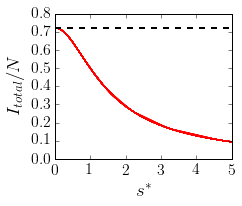

In [77]:
figure(figsize=(3.5,3))
ax1 = gca()
#ax2 = plt.twiny(ax1)
c=0
c_ex=arange(len(tinfo))

cols = get_cmap('winter', len(tD))

for iD,D in enumerate(tD):
    for iN, N in enumerate(tN):
        if c in c_ex:
            Mv = np.arange(len(tinfo[c]))+1

            #ax1.plot(Mv/N*D, tinfo[c]/N, c=cols(iD), lw=2)
        
            ax1.plot((N/Mv/D)**0.5, tinfo[c]/N, 'r')
        c+=1

ax1.plot([0, 5], [1/2/np.log(2), 1/2/np.log(2)], '--k', lw=2)
        
ax1.set_xlim([0, 5])
ax1.set_xlabel(r'$s^*$')
ax1.set_ylabel(r'$I_{total}/N$')
#ax2.set_xlim([1/tN.max(), 3])
#ax2.set_xlabel('$s$')

plt.tight_layout()
fname = ('figures/coef_extensive_linear-s'
         + '-lN='+ str(len(tN))
         + '-n' + time.strftime('%y%m%d'))
    
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

#xscale('log')

In [1057]:
import sympy.mpmath

In [1058]:
sympy.mpmath.qp(b_M*q, q)

mpf('1.2574603035491882e+32')

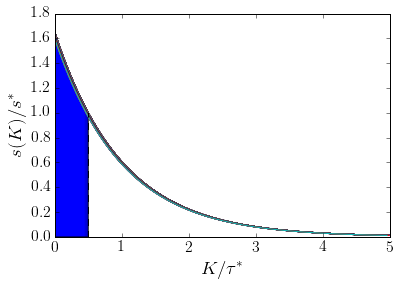

In [27]:
ttN=2e3
ttD = np.logspace(0, 2, 10)
test_snr = np.logspace(0.2, 1, 20)

for iD, D in enumerate(ttD):
    for isnr, snrv in enumerate(test_snr):
        t_s = test_snr[isnr] / D**0.5
        tau_star = 2/(t_s**2 * np.exp(1)) *ttN / D 
        ll = np.exp(-1/tau_star)
        K_star = tau_star/2
        #pcd = p_correct_decay(np.arange(K_star[isnr]), N=N, ll=ll, D=D)
        K = np.arange(10*K_star)
        snrK = ll**K * (ttN * (1-ll**2)/D)**0.5
        
        plot(K/tau_star, snrK/t_s)
        
        K_f = np.arange(K_star)
        snrK_f = ll ** K_f * (ttN * (1-ll**2)/D)**0.5
        fill_between(K_f/tau_star, np.zeros_like(K_f), snrK_f/t_s, alpha=0.01)
        
        
        #plot([0, 0.5], [1, 1], '--k')
        plot([0.5, 0.5], [0, 1], '--k')
        
xlabel(r'$K / \tau^*$')
ylabel(r'$s(K) / s^*$')

In [66]:
ttN=1e4
ttD = np.logspace(0, 2, 10)
test_snr = np.logspace(0.1, 1, 100)

#pcd = p_correct_decay(t, N=N, ll=ll, D=D)
#total_info = cumsum(pcd * np.log2(pcd*D) + (1-pcd) * np.log2(D/(D-1) * (1-pcd)))

total_ginfo_star = np.zeros((len(ttD), len(test_snr)))
total_ginfo_fstar = np.zeros((len(ttD), len(test_snr)))
total_ginfo_2star = np.zeros((len(ttD), len(test_snr)))
total_ginfo_qstar = np.zeros((len(ttD), len(test_snr)))


#tau_star = -2*N/np.log(1-test_snr**2/N)

#K_star = tau_star / 2 #

for iD, D in enumerate(ttD):
    for isnr, snrv in enumerate(test_snr):
        
        tau_star = 2/(test_snr[isnr]**2 * np.exp(1)) *ttN
        ll = np.exp(-1/tau_star)
        K_star = tau_star/2
        #pcd = p_correct_decay(np.arange(K_star[isnr]), N=N, ll=ll, D=D)
        K = np.arange(K_star)
        snrK = ll**K * (ttN * (1-ll**2)/D)**0.5
        total_ginfo_star[iD, isnr] = D/2*np.sum(np.log2(snrK**2+1))
        
        
        Kf = np.arange(K_star*2)
        snrKf= ll**Kf * (ttN * (1-ll**2)/D)**0.5
        total_ginfo_2star[iD, isnr] = D/2*np.sum(np.log2(snrKf**2+1))
        
        Kf = np.arange(K_star*20)
        snrKf= ll**Kf * (ttN * (1-ll**2)/D)**0.5
        total_ginfo_fstar[iD, isnr] = D/2*np.sum(np.log2(snrKf**2+1))
        
        #b_M = N*(1-np.exp(-2/tau_star))/D
        #q = np.exp(-2/tau_star)

        #total_ginfo_qstar[iD, isnr] = D/2*(np.log2(float32(sympy.mpmath.qp(-b_M*q, q))))

        #total_ginfo_qstar[iD, isnr] = D/2*(-tau_star/2 * scipy.special.spence(b_M * q))
    


In [67]:
1/exp(-0.5)

1.6487212707001282

figures/constant_snr-I_total-N=10000-ls=100-n170907


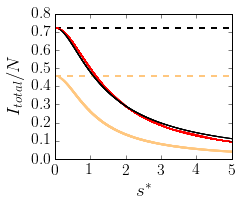

In [76]:
figure(figsize=(3.5, 3))

cols = get_cmap('copper', 3)


plot([0, test_snr.max()], [1/(2*np.log(2)), 1/(2*np.log(2))], '--k', lw=2)
plot([0, test_snr.max()], [(1-np.exp(-1))/(2*np.log(2)), (1-np.exp(-1))/(2*np.log(2))], '--', lw=2, c=cols(2))


c=0
c_ex=arange(len(tinfo))

for iD,D in enumerate(tD):
    for iN, N in enumerate(tN):
        if c in c_ex:
            Mv = np.arange(len(tinfo[c]))+1

            plot((N/Mv/D)**0.5, tinfo[c]/N, 'r')
        c+=1
        
for iD, D in enumerate(ttD):
    
    plot(test_snr/D**0.5, total_ginfo_star[iD, :]/ttN, lw=2, c=cols(2))
    
    #plot(test_snr/D**0.5, total_ginfo_2star[iD, :]/N, lw=1, c=cols(1))
    plot(test_snr/D**0.5, total_ginfo_fstar[iD, :]/ttN, lw=1, c=cols(0))




xlabel('$s^*$')
ylabel('$I_{total}/N$')

xlim([0, 5])
ylim([0, 0.8])

plt.tight_layout()

fname = ('figures/constant_snr-I_total-N=' + str(int(ttN)) 
         + '-ls=' +str(len(test_snr)) + '-n' + time.strftime('%y%m%d')
         )

print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

In [953]:
tN = np.logspace(3, 6, 10)
tD = tN/tN[0] #[1, 2, 4, 8, 16, 32, 64]

test_factors = np.logspace(-2, 2, 50)#[0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2]

total_info = np.zeros((len(tN), len(tD), len(test_factors)))
tst = time.time()
for itf, tau_factor in enumerate(test_factors):
    for iD,D in enumerate(tD):
        for iN, N in enumerate(tN):

            K = arange(3*N)
            
            tauv = N*tau_factor
            ll = np.exp(-1/tauv)
            s_eta = 0 #0.01 #0.01*D

            s = ll**K * (N*(1-ll**2)/(D*(1+s_eta)))**0.5

            info = D/2 * np.log2(s**2+1)

            total_info[iN, iD, itf] = info.sum()
print 'elapsed:', time.time()-tst

elapsed: 251.801403046


In [53]:
tD[3]

10.0

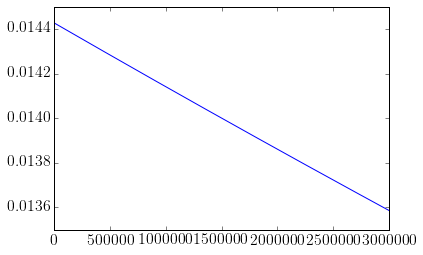

In [954]:
plot(info)

figures/coef_decay_extensive_noise-lN=10-ltf=50-s_n=0-D=3-n170831


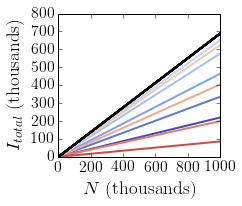

In [986]:
figure(figsize=(3.5,3))
iD = 3
cols = get_cmap('coolwarm', len(test_factors))

ffN = 1000

for itf, tau_factor in enumerate(test_factors):
    if itf % 5 == 0:
        plot(tN/ffN, total_info[:, iD, itf]/ffN, c=cols(itf), lw=2)
    
tau_max_idxs = np.argmax(total_info[:, iD, :], axis=1)

plot(tN/ffN, total_info[:, iD, tau_max_idxs]/ffN, 'k', lw=2)

#xscale('log')
#yscale('log')
xlabel('$N$ (thousands)')
ylabel('$I_{total}$ (thousands)')
ylim([0, 800])
plt.tight_layout()

fname = ('figures/coef_decay_extensive_noise-I_linear-'
         + '-lN='+ str(len(tN)) +'-ltf=' + str(len(test_factors)) 
         + '-s_n=' + str(s_eta)
         + '-D=' + str(iD) + '-n' + time.strftime('%y%m%d'))
    
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

In [51]:
figure(figsize=(3.5,3))

cols= get_cmap('jet', len(tN))
h_plot = []

for iN, N in enumerate(tN):
    tau_max_idx = int(np.mean(np.argmax(total_info[:, iD, :], axis=1)))
    hp, = plot(test_factors * N, total_info[iN, iD, :]/N, lw=2, c=cols(iN), 
                  label=r'$N=%i$'%N)
    h_plot.append(hp)
    #plot(test_factors[tau_max_idx], total_info[-1, iD, tau_max_idx].T/tN[-1] , 'ok', ms=5)
    
plot([test_factors[0]*tN[0], test_factors[-1]*tN[-1]], [1/(2*log(2)), 1/(2*log(2)) ], '--k', lw=2)

xscale('log')
xlabel(r'$\tau$')
ylabel(r'$I_{total}/N$')
#legend(handles=[h_plot[0], h_plot[-1]], loc='lower right')
ylim([0, 0.8])
plt.tight_layout()

fname = ('figures/coef_decay_extensive_noise-exN'
         + '-lN='+ str(len(tN)) +'-ltf=' + str(len(test_factors)) 
         + '-s_n=' + str(s_eta)
         + '-D=' + str(tD[iD]) + '-n' + time.strftime('%y%m%d'))
    
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

NameError: name 'total_info' is not defined

In [903]:
t_infoN = total_info/tN[:, np.newaxis, np.newaxis]
t_infoN = t_infoN.mean(axis=0)

figures/coef_decay_extensive_noise-norm_tau-lN=10-ltf=50-s_n=0-D=9-n170904


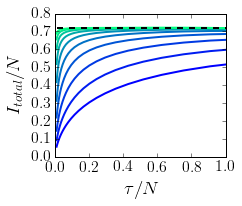

In [1031]:
figure(figsize=(3.5,3))

cols= get_cmap('winter', len(tD))
h_plot = []

for iD, D in enumerate(tD):
    tau_max_idx = int(np.mean(np.argmax(total_info[:, iD, :], axis=1)))
    hp, = plot(test_factors, t_infoN[iD, :], lw=2, c=cols(iD), 
                  label=r'$D=%i$'%D)
    h_plot.append(hp)
    #plot(test_factors[tau_max_idx], total_info[-1, iD, tau_max_idx].T/tN[-1] , 'ok', ms=5)
    
    
plot(test_factors, 1/(2*log(2)) * np.ones_like(test_factors), '--k', lw=2)
#xscale('log')
xlim([0, 1])
xlabel(r'$\tau/N$')
ylabel(r'$I_{total}/N$')
#legend(handles=[h_plot[0], h_plot[-1]], loc='lower right')

plt.tight_layout()

fname = ('figures/coef_decay_extensive_noise-norm_tau'
         + '-lN='+ str(len(tN)) +'-ltf=' + str(len(test_factors)) 
         + '-s_n=' + str(s_eta)
         + '-D=' + str(iD) + '-n' + time.strftime('%y%m%d'))
    
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

figures/coef_decay_extensive_noise-tauD-lN=10-ltf=50-D=9-n170904


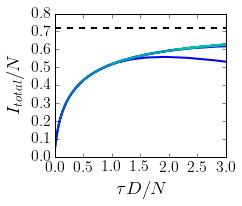

In [1032]:
figure(figsize=(3.5,3))

cols= get_cmap('winter', len(tD))
h_plot = []

for iD, D in enumerate(tD):
    tau_max_idx = int(np.mean(np.argmax(total_info[:, iD, :], axis=1)))
    hp, = plot(test_factors*D, t_infoN[iD, :], lw=2, c=cols(iD), 
                  label=r'$D=%i$'%D)
    h_plot.append(hp)
    #plot(test_factors[tau_max_idx], total_info[-1, iD, tau_max_idx].T/tN[-1] , 'ok', ms=5)


plot([test_factors[0], test_factors[-1]*tD.max()], [1/(2*log(2)), 1/(2*log(2)) ], '--k', lw=2)

#xscale('log')
#xlim([1e-1, 1e3])
xlim([0, 3])
xlabel(r'$\tau D/N$')
ylabel(r'$I_{total}/N$')
#legend(handles=[h_plot[0], h_plot[-1]], loc='lower right')

plt.tight_layout()

fname = ('figures/coef_decay_extensive_noise-tauD'
         + '-lN='+ str(len(tN)) +'-ltf=' + str(len(test_factors)) 
         + '-D=' + str(iD) + '-n' + time.strftime('%y%m%d'))
    
print fname
savefig(fname + '.png', format='png', transparent=True)
savefig(fname + '.eps', format='eps', transparent=True)

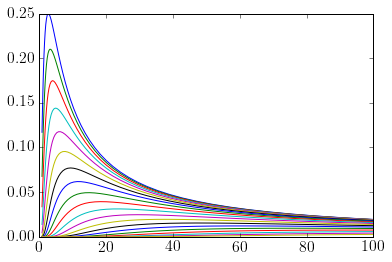

In [1021]:

ttau = np.logspace(0, 2, 50)
tlambda = np.exp(-1/ttau)
tK = np.logspace(0, 2, 20)

for iK, Kv in enumerate(tK):
    plot(ttau, tlambda**(2*Kv) * (1-tlambda**2))

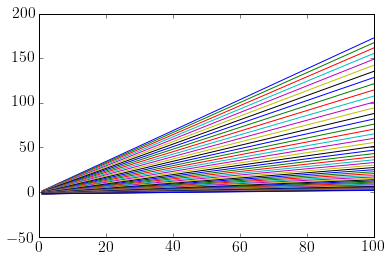

In [1022]:
for ill, llv in enumerate(tlambda):
    plot(tK, 2*tK*(1-llv**2)-2*llv**2)

In [759]:
h_plot[iD] = hp

TypeError: float() argument must be a string or a number

In [875]:
s_eta=0

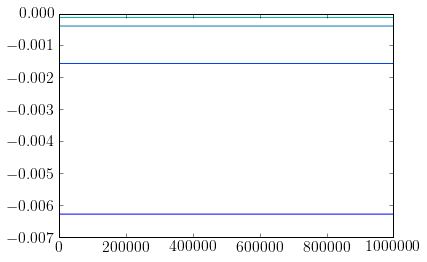

In [888]:
N = np.logspace(3,6, 100)
D = 16
beta = 10


tD = [16, 64, 256, 1024, 4096]
cols = get_cmap('winter', len(tD))
for iD, D in enumerate(tD):
    b_M = N*(1-np.exp(-2/beta/N))/D/(1+s_eta)
    q = np.exp(-2/beta/N)

    ll_app = 0.5 * np.log(1 -  b_M * q)

    plot(N, ll_app, c=cols(iD))


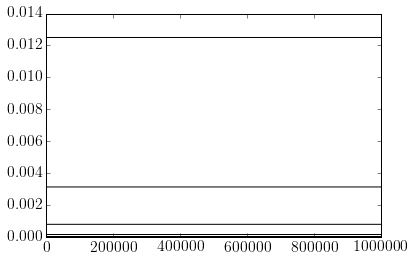

In [897]:
import scipy.special

tD = [16, 64, 256, 1024, 4096]
cols = get_cmap('winter', len(tD))
for iD, D in enumerate(tD):
    b_M = N*(1-np.exp(-2/beta/N))/D/(1+s_eta)
    q = np.exp(-2/beta/N)

    ll_app2 = beta * N/2 * scipy.special.spence(b_M * q)

    #plot(N, ll_app2, c=cols(iD))
    plot(N, b_M * q, 'k')


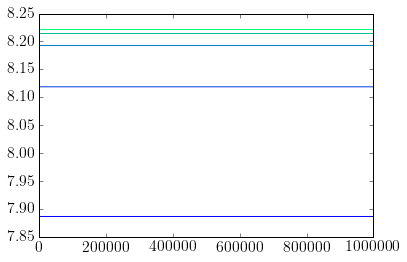

In [895]:

for iD, D in enumerate(tD):
    b_M = N*(1-np.exp(-2/beta/N))/D/(1+s_eta)
    ll_app2 = beta * N/2 * scipy.special.spence(b_M * q)

    plot(N, ll_app2/N, c=cols(iD))
    


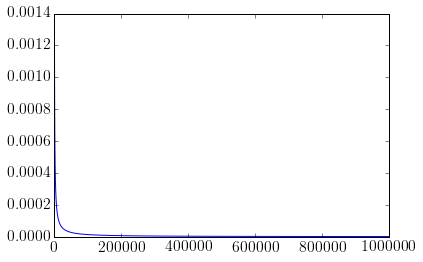

In [856]:
ll_app3 = 2/12/beta/N * b_M*q/(1-b_M*q)

plot(N, ll_app3)

In [8]:

def p_correct_snr(s, D=27, ares=2000):
    p = np.zeros((ares-1, len(s)))

    for isnr, snr in enumerate(s):
        # span the Hit distribution up to 8 standard deviations @todo: make parameter
        avals = np.linspace(snr - 8, snr + 8, ares)
        
        # the discretized gaussian of the hit
        p[:, isnr] = ncdf((avals[1:]-snr)) - ncdf((avals[:-1]-snr))
        # times the discretized cumulative gaussian of the reject
        p[:, isnr] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0))) ** (D-1)
        
    return np.sum(p, axis=0) # integrate over the avals



In [303]:
def gauss_MI(N, M, D, ares=2000):
    sigma2=1
    
    avals = np.linspace(-10, 10, ares)
    info = np.zeros((ares-1, len(M)))
    
    p_y = ncdf(avals[1:])-ncdf(avals[:-1])
    
    for iM, Mv in enumerate(M):
        print iM,
        MD = Mv * D - 1
        p_x = ncdf(avals[1:] / (1+MD/N)**0.5) - ncdf(avals[:-1] / (1+MD/N) **0.5)
    
        for iy, yv in enumerate(avals[:-1]):           
            p_xy = ncdf((avals[1:]-yv) / (MD/N)**0.5) - ncdf((avals[:-1]-yv) / (MD/N)**0.5)
            pp = p_y[iy] * p_xy * np.log2(p_xy/p_x)
            pp[p_xy < 1e-10] = 0
            
            info[iy, iM] = np.nansum(pp, axis=0)
        
    return np.nansum(info, axis=0)

In [412]:
def test_gauss_info(N, M, D):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)
    
    input_vec = np.random.randn(D, M)
    
    for i in range(M):
        hypercapacity = np.roll(hypercapacity, 1) + np.dot(letter_vectors.T, input_vec[:,i])
        
    output_vec = np.zeros_like(input_vec)
    for i in range(M):
        v_decode = np.roll(hypercapacity, -(M-i-1))
        output_vec[:, i] = np.dot(letter_vectors, v_decode) / N
    
    return output_vec, input_vec

In [495]:
N=1000
M=2
D=16
out_vec, in_vec = test_gauss_info(N, M, D)


In [496]:
ares=2000

in_edges = np.linspace(in_vec.min(), in_vec.max(), ares)
out_edges = np.linspace(out_vec.min(), out_vec.max(), ares)

in_hist, in_e = np.histogram(in_vec.ravel(), in_edges)
out_hist, out_e = np.histogram(out_vec.ravel(), out_edges)
joint_hist, in_e, out_e = np.histogram2d(in_vec.ravel(), out_vec.ravel(), bins=[in_edges, out_edges])

In [497]:
joint = joint_hist / np.sum(joint_hist)
p_in = in_hist / np.sum(in_hist)
p_out = out_hist / np.sum(out_hist)

info_mat= joint * np.log2(joint / (p_in[:, np.newaxis] * p_out[:, np.newaxis].T))

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log2
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in multiply


In [646]:
N = 1000
tM = np.arange(200)+1
D = 2

reps = 5

total_info_est = np.zeros(len(tM))

error = np.zeros(len(tM))

ares=501
in_edges = np.linspace(-10, 10, ares)


for iM, Mv in enumerate(tM):
    print Mv,
    
    out_vec = np.zeros((D, Mv*reps))
    in_vec = np.zeros((D, Mv*reps))
    
    for r in range(reps):
        ov, inv = test_gauss_info(N, Mv, D)
        
        out_vec[:, r*Mv:((r+1)*Mv)] = ov
        in_vec[:, r*Mv:((r+1)*Mv)] = inv
    
    in_hist, in_e = np.histogram(in_vec.ravel(), in_edges)
    out_hist, out_e = np.histogram(out_vec.ravel(), in_edges)
    joint_hist, in_e, out_e = np.histogram2d(in_vec.ravel(), out_vec.ravel(), in_edges)
    
    joint = joint_hist / np.sum(joint_hist)
    p_in = in_hist / np.sum(in_hist)
    p_out = out_hist / np.sum(out_hist)

    info_mat= joint * np.log2(joint / (p_in[:, np.newaxis] * p_out[:, np.newaxis].T))
    
    total_info_est[iM] = np.nansum(info_mat)
    
    
    error[iM] = np.mean((in_vec - out_vec)**2)**0.5

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log2
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in multiply


 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200


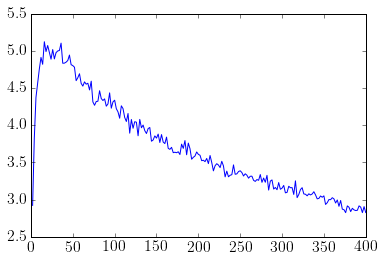

In [647]:
plot(tM*D, total_info_est)


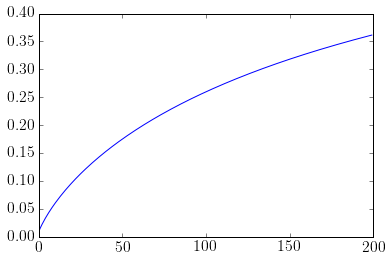

In [654]:
snr2 = N/tM/D
info2 = 0.5 * np.log2((snr2+1))

info_tot = tM * D * info2 / N
plot(info_tot)

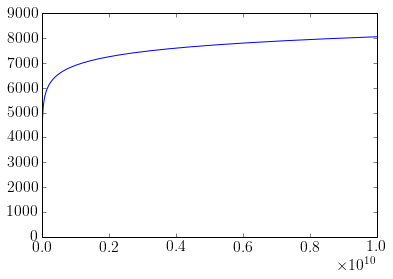

In [660]:
MD = 1000
N = np.logspace(3, 10, 100)
snr2 = N/MD
x=1/(snr2+1)

I_tt = -MD/2*(snr2+1)*(x**x - 1)

plot(N, I_tt)
#xscale('log')

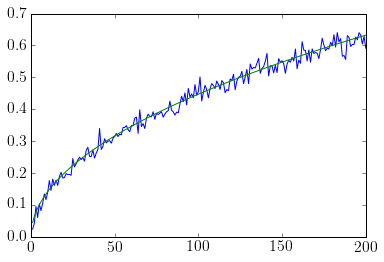

In [655]:
plot(tM, error)
plot(tM, 1/(N/tM/D)**0.5)

In [624]:
in_vec.min()

-2.9250940749761307

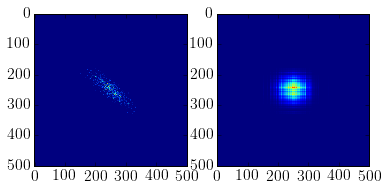

In [625]:
figure(figsize=(6,4))
subplot(121)
imshow(joint)
subplot(122)
imshow(p_in[:, np.newaxis]* p_out[:, np.newaxis].T)


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


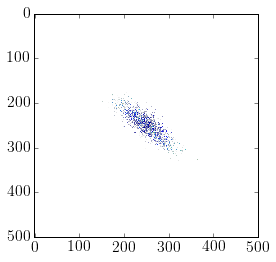

In [628]:
imshow(joint * np.log2(joint / (p_in[:, np.newaxis] * p_out[:, np.newaxis].T)))

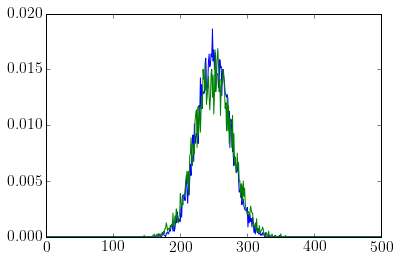

In [609]:
plot(p_in)
plot(p_out)

In [600]:
print np.var(in_vec), np.var(out_vec)

0.967957114737 1.16397514136


In [601]:
np.corrcoef(in_vec.ravel(), out_vec.ravel())

array([[ 1.        ,  0.91507664],
       [ 0.91507664,  1.        ]])

In [602]:
snr = (N/M/D)**0.5
rho = 1 / (1 + 1/snr**2)**0.5
print rho

0.999001497504


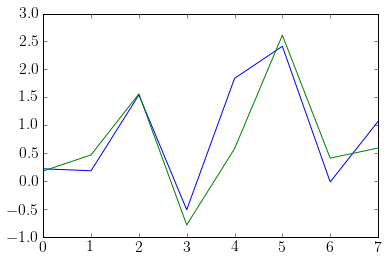

In [603]:
plot(in_vec[:, 6])
plot(out_vec[:,6])

In [273]:
N=1000
ares=2000
avals = np.linspace(-10,10,ares)
MD = 100

p_y = ncdf(avals[1:])-ncdf(avals[:-1])        
p_xy = ncdf(avals[1:] / (MD/N)**0.5) - ncdf(avals[:-1] / (MD/N)**0.5-1)
p_x = ncdf(avals[1:] / (1+MD/N)**0.5) - ncdf(avals[:-1] / (1+MD/N) **0.5)
    

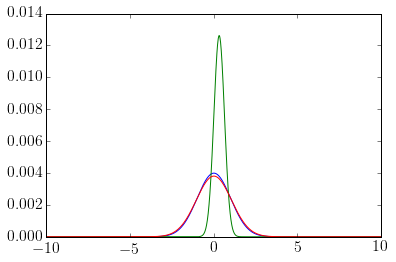

In [274]:
plot(avals[1:], p_y)
plot(avals[1:], p_xy)
plot(avals[1:], p_x)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


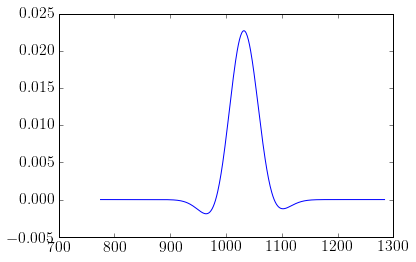

In [275]:
plot(p_xy * np.log2(p_xy/p_x))

In [308]:
N=200
M=np.arange(200)+1
D=12
gauss_info = gauss_MI(N, M, D, ares=1000)

0 1

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in true_divide
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log2
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in multiply


 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199


(0, 1)

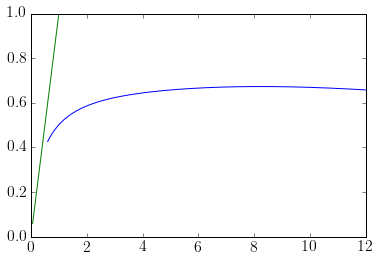

In [309]:
plot(M*D/N, M*D*gauss_info/N)
plot(M*D/N, M*D/N)
ylim([0,1])

In [437]:
Ns = 10000
sigma_a = 1
sigma_ba = 0.2

p_a = sigma_a * np.random.randn(Ns)
p_ba = p_a + sigma_ba * np.random.randn(Ns)

In [438]:
s = np.logspace(-2, 2, 100)
dkdt = np.log(s)/(1-np.exp(-2/ ))

1.0211262060573103

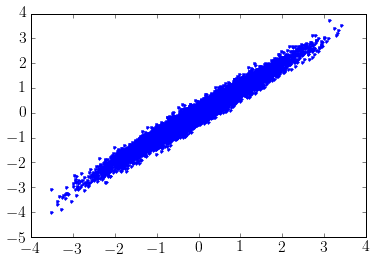

In [439]:
plot(p_a, p_ba, '.')

In [443]:
snr = np.linspace(0, 20, 100)
snr_cc = np.zeros_like(snr)

for isnr, snrv in enumerate(snr):
    sigma_ba = 1/snrv #(1+1/snrv**2)**0.5
    p_a = sigma_a * np.random.randn(Ns)
    p_ba = p_a + sigma_ba * np.random.randn(Ns)
    
    snr_cc[isnr] = np.corrcoef(p_a, p_ba)[0,1]

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


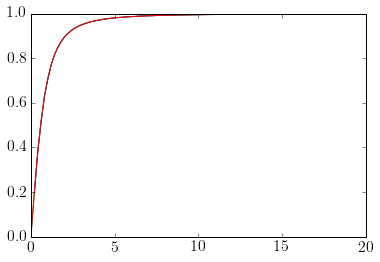

In [444]:
sigma = 1
rho = sigma**2 / (sigma * (sigma**2 + 1/snr**2)**0.5)
rho2 = 1 / (1 + 1/snr**2)**0.5

plot(snr, snr_cc)
plot(snr, rho)
plot(snr, rho2)

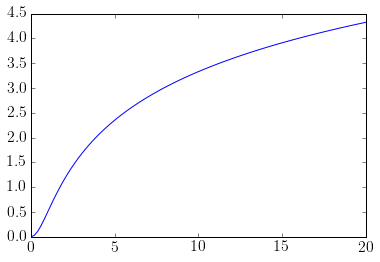

In [445]:
info = -0.5 * np.log2(1-rho**2)

plot(snr, info)

In [403]:
N=1000
M=np.arange(5*N)+1
D=32

sigma = 1

snr2 = N/(M*D-1)

rho = 1 / (1 + 1/snr2)**0.5

info = -0.5 * np.log2(1-rho**2)

info2 = -0.5 * np.log2(1/(snr2+1))

info_tot = M * D * info2 / N

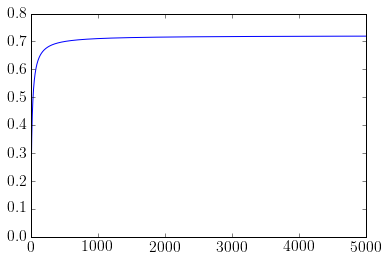

In [404]:
plot(M, info_tot)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


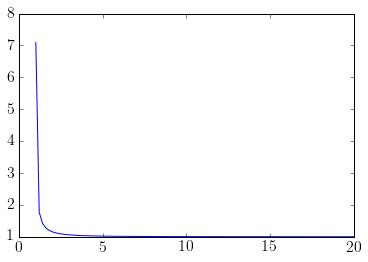

In [363]:

plot(snr, 1/(1-1/snr**2)**0.5)

#ylim([0,1])

In [329]:
print np.corrcoef(p_a, p_ba)
print 1-1/sigma_ba**2 


[[ 1.          0.68534313]
 [ 0.68534313  1.        ]]
9.99900009997e-05


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


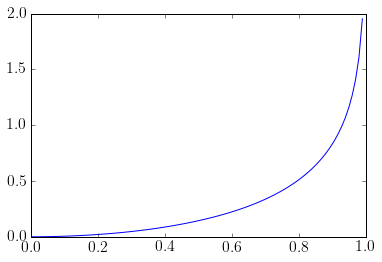

In [324]:
rho = np.linspace(0, 1, 100)
plot(rho, -0.5 * np.log(1-rho**2))

In [295]:
gauss_info

array([        inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,         inf,
               inf,         inf,         inf,         inf,  0.70755391,
        0.67881183,  0.65246358,  0.62820647,  0.60578882,  0.58499933,
        0.56565907,  0.54761534,  0.53073685,  0.51491006,  0.50003616,
        0.48602872,  0.47281174,  0.4603181 ,  0.44848827,  0.43726926,
        0.42661367,  0.41647904,  0.40682713,  0.39762345,  0.38883679,
        0.38043883,  0.37240378,  0.36470818,  0.35733052,  0.35025115,
        0.34345201,  0.3369165 ,  0.33062933,  0.32457638,  0.3187446 ,
        0.3131219 ,  0.30769707,  0.30245971,  0.29740013,  0.29250931,
        0.28777884,  0.28320086,  0.27876803,  0.27447347,  0.27031073,
        0.26627378,  0.26235693,  0.25855485,  0.25486251,  0.25127519,
        0.24778841,  0.24439798,  0.24109991,  0.23789045,  0.23476604,
        0.23172331,  0.22875907,  0.22587031,  0.22305414,  0.22

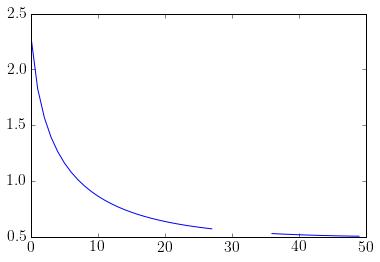

In [277]:
plot(gauss_info)